In [1]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score

from sklearn import preprocessing

import tensorflow as tf 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import Adam

import pickle
import numpy as np
import matplotlib.pyplot as plt

# Preparing the data

In [2]:
data_path ="/content/drive/MyDrive/Aimtech/"
# data_path ="./"

In [3]:
with open(data_path+"clean_data.pickle", "rb") as f:
    (X,y) = pickle.load(f)

In [4]:
# Splitting the data into train and validation sets with ratio 80 : 20 
X_train, X_test, y_train, y_test = train_test_split(X.flatten(),y, test_size=0.2,stratify=y,random_state=0)
print(X_train.shape)
print(X_test.shape)

(133142,)
(33286,)


In [ ]:
# X.flatten()

In [ ]:
# vectorizer = TfidfVectorizer(lowercase=False)
# X_test = vectorizer.fit_transform(X_train.flatten() )

# SVM model
**Training of an SVM classifier with tfidf vectorization.**

In [ ]:
# TF-IDF transformation then SVM classifier

pipe_SVM= Pipeline([('tfidf', TfidfVectorizer(lowercase=False)),
               ('clf',svm.SVC(kernel='linear', C=1)),
              ])
pipe_SVM.fit(X_train, y_train)
y_pred_SVM= pipe_SVM.predict(X_test)

#Evaluation
print('\033[1m{:10s}\033[0m'.format('TF-IDF_SVM_model'))
print("Report : \n",classification_report(y_test, y_pred_SVM))
print('\033[1m{:10s}\033[0m'.format("Accuracy:"),accuracy_score(y_test, y_pred_SVM))

TF-IDF_SVM_model
Report : 
               precision    recall  f1-score   support

          AE       0.33      0.38      0.36      1850
          BH       0.28      0.32      0.30      1849
          DZ       0.54      0.55      0.54      1849
          EG       0.59      0.68      0.63      1849
          IQ       0.54      0.59      0.56      1849
          JO       0.37      0.35      0.36      1850
          KW       0.37      0.37      0.37      1849
          LB       0.57      0.56      0.57      1849
          LY       0.58      0.52      0.55      1849
          MA       0.73      0.62      0.67      1849
          OM       0.31      0.37      0.34      1849
          PL       0.38      0.35      0.37      1849
          QA       0.41      0.38      0.39      1850
          SA       0.31      0.38      0.34      1849
          SD       0.69      0.60      0.64      1849
          SY       0.45      0.38      0.41      1850
          TN       0.65      0.55      0.59      1849

In [ ]:
# saving the data as a pickle file to reuse later
with open(data_path+"ml_pipe.pickle", "wb") as f:
    pickle.dump((pipe_SVM),f)

# Deep learning model

In [5]:
nClasses=len(np.unique(y))
nClasses

18

**Label encoding the target variable.**

In [6]:
le = preprocessing.LabelEncoder()

y_train_le= le.fit_transform(y_train)
y_test_le= le.transform(y_test)

y_train_k = tf.keras.utils.to_categorical(y_train_le, num_classes=nClasses)
y_test_k = tf.keras.utils.to_categorical(y_test_le, num_classes=nClasses)

**Tokinizing the text**

In [7]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [8]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1 

**Padding each sentence to have 100 words per sentence.**

In [9]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

**Initializing the model**

In [10]:
embedding_dim = 300

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Dropout(0.2))

# model.add(layers.LSTM(units=32, return_sequences=True, return_state=False))
model.add(layers.LSTM(units=16, return_sequences=True, return_state=False))

model.add(layers.Flatten())

# model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(nClasses, activation='sigmoid'))

opt = Adam(learning_rate = 0.001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])



In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          72305100  
                                                                 
 dropout (Dropout)           (None, 100, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100, 16)           20288     
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 32)                51232     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 18)                5

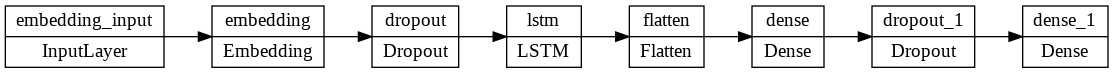

In [12]:
tf.keras.utils.plot_model(
    model, to_file=data_path+'model.png',
    show_layer_names=True, rankdir='LR'
)

**Model Training**

In [ ]:

batchSize = 32
nEpochs = 10

history = model.fit(X_train, y_train_k,
                    epochs=nEpochs,
                    validation_data=(X_test, y_test_k),
                    batch_size=batchSize )

Epoch 1/10
4161/4161 [==============================] - 316s 75ms/step - loss: 2.2200 - accuracy: 0.2857 - val_loss: 1.9432 - val_accuracy: 0.3833
Epoch 2/10
4161/4161 [==============================] - 310s 74ms/step - loss: 1.8609 - accuracy: 0.4130 - val_loss: 1.8814 - val_accuracy: 0.4054
Epoch 3/10
4161/4161 [==============================] - 309s 74ms/step - loss: 1.7220 - accuracy: 0.4568 - val_loss: 1.8886 - val_accuracy: 0.4097
Epoch 4/10
4161/4161 [==============================] - 309s 74ms/step - loss: 1.6150 - accuracy: 0.4889 - val_loss: 1.9073 - val_accuracy: 0.4074
Epoch 5/10
4161/4161 [==============================] - 312s 75ms/step - loss: 1.5226 - accuracy: 0.5184 - val_loss: 1.9868 - val_accuracy: 0.4010
Epoch 6/10
4161/4161 [==============================] - 310s 75ms/step - loss: 1.4385 - accuracy: 0.5423 - val_loss: 2.0317 - val_accuracy: 0.4007
Epoch 7/10
4161/4161 [==============================] - 309s 74ms/step - loss: 1.3683 - accuracy: 0.5665 - val_loss: 2

**Model Evaluation**

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train_k, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_k, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.7060
Testing Accuracy:  0.3830


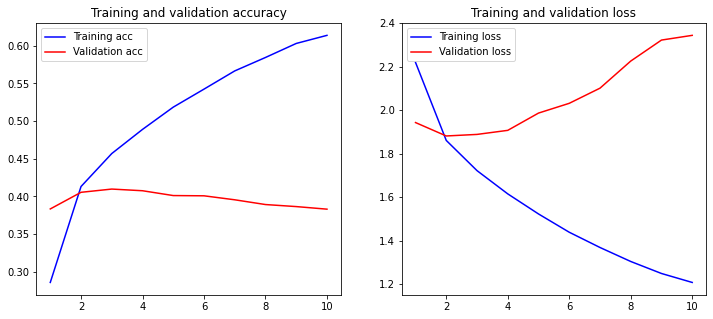

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
model.save_weights(data_path+'weights.h5')

**The deep learning model is overfitting the training data from the first two epochs. However, decreasing the tokenizer's number of words reduces the overfitting.**

# Comparison

**As shown above both models have low accuracy. However, the deep learning model is also overfitting making the SVM model our champion model. Accuracy is chosen as out metric because the data is balanced amoung all classes.**